In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [12]:
data = pd.read_parquet('train_data_leakage.parquet.gzip').to_numpy().astype(np.float32)

data = data[: int(0.01 * len(data))]

data.shape

(90737, 31)

# Create and Train Model

In [15]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.lstm1 = nn.GRU(30, 30, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(0.23)
        self.lstm2 = nn.GRU(30, 30, batch_first=True, bidirectional=False)
        self.linear1 = nn.Linear(30, 15)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(15, 15)
        self.linear3 = nn.Linear(15, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout(out)
        out, _ = self.lstm2(out)
        out = self.linear1(out)
        out = self.tanh(out)
        out = self.linear2(out)
        out = self.tanh(out)
        out = self.linear3(out)
        return out


target_idx = 1
feature_columns = list(range(data.shape[1]));feature_columns.remove(target_idx)

# Aufteilen der Daten in Trainings- und Testsets
train_df, test_df = train_test_split(data, test_size=0.2)

# Konvertieren der Daten in PyTorch-Tensoren
X_train = torch.tensor(train_df[:, feature_columns], dtype=torch.float32)
y_train = torch.tensor(train_df[:, target_idx], dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test_df[:, feature_columns], dtype=torch.float32)
y_test = torch.tensor(test_df[:, target_idx], dtype=torch.float32).view(-1, 1)

# Erstellen von DataLoader-Objekten für das effiziente Laden von Daten während des Trainings
batch_size = 512
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# Instantiieren Sie das Modell
model = MyModel()

# Definition von Verlust und Optimierer
criterion = nn.L1Loss()  # Mean Absolute Error
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Ausgabe des Verlusts pro Epoche
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Duration: {round((time.time() - start_time)/60, 3)}')

Epoch 1/10, Loss: 46.89226150512695, Duration: 0.199
Epoch 2/10, Loss: 44.23639678955078, Duration: 0.199
Epoch 3/10, Loss: 41.77980422973633, Duration: 0.203
Epoch 4/10, Loss: 39.391563415527344, Duration: 0.203
Epoch 5/10, Loss: 37.03792190551758, Duration: 0.203
Epoch 6/10, Loss: 34.7050666809082, Duration: 0.205
Epoch 7/10, Loss: 32.386009216308594, Duration: 0.199
Epoch 8/10, Loss: 30.076663970947266, Duration: 0.199
Epoch 9/10, Loss: 27.77449607849121, Duration: 0.199
Epoch 10/10, Loss: 25.477773666381836, Duration: 0.201


In [28]:
# Evaluierung des Modells auf dem Testset
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item()}')
    print("Test Array Shape: ", test_outputs.shape)
    print(test_outputs.flatten())

Test Loss: 25.45281410217285
Test Array Shape:  torch.Size([18148, 1])
tensor([25.1178, 25.1190, 25.1191,  ..., 25.1192, 25.1192, 25.1192])


In [ ]:
#we need to train the 29 Models 

models = []

for sensor_idx in range(1):
    
    inputs_idx = list(range(data.shape[1]));inputs_idx.remove(sensor_idx)
            
    X, y = data[:,inputs_idx], data[:,sensor_idx]
    
    X = np.array(X).reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y).reshape(y.shape[0],1)
    
    model = create_model()
    
    with tf.device('/gpu:0'):
    
        hist = model.fit(X,y,batch_size=512, epochs=20, validation_split=0.2)
    
    models.append({'model_id' : sensor_idx, 'model' : model, 'hist' : hist, 'inputs_idx':inputs_idx})

In [68]:
model_1 = models[0]['model']
model_2 = models[1]['model']
model_3 = models[2]['model']

h_1 = models[0]['hist'].history
h_2 = models[1]['hist'].history
h_3 = models[2]['hist'].history

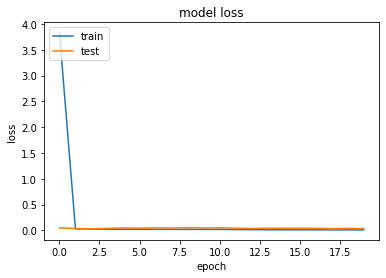

In [13]:
#plot the metrics during the training
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

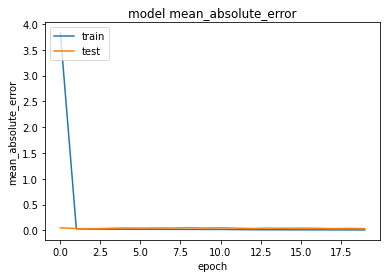

In [14]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

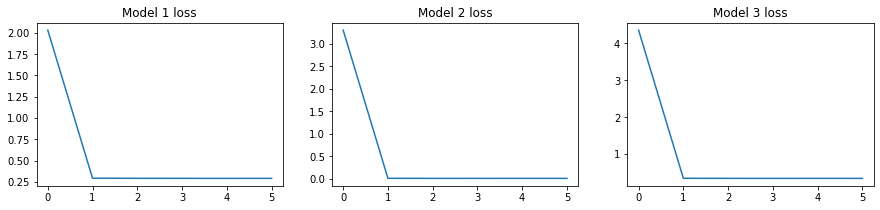

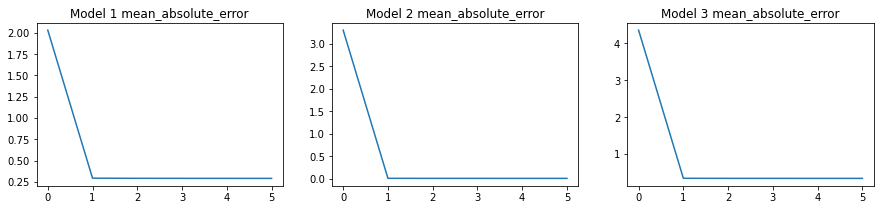

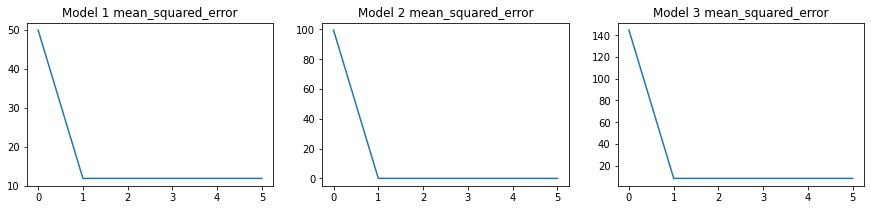

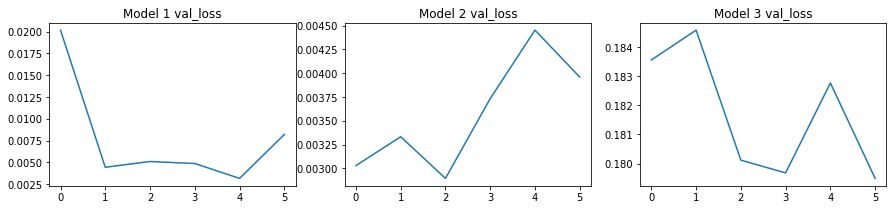

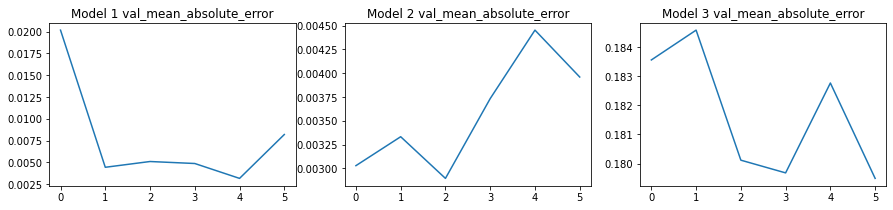

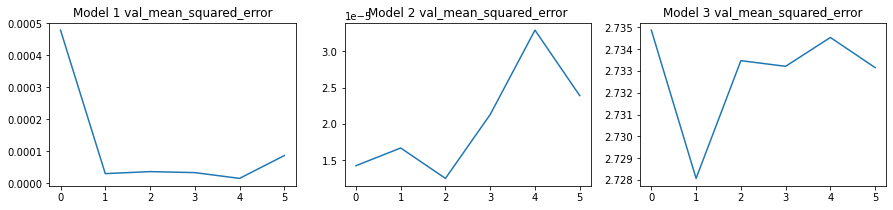

In [90]:

for key in h_1.keys():
    
    # Plots erstellen
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    axes[0].plot(h_1[key])
    axes[0].set_title(f"Model 1 {key}")

    axes[1].plot(h_2[key])
    axes[1].set_title(f"Model 2 {key}")

    axes[2].plot(h_3[key])
    axes[2].set_title(f"Model 3 {key}")
    
    plt.show()

In [1]:
import os
test_data_path_0 = '/Users/florianwicher/Desktop/TestData/LeakageScenariosTest_1'



/var/folders/24/dwryd6_d22d4mw0dwwkwbcjh0000gn/T/ipykernel_1654/2086661600.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,5))


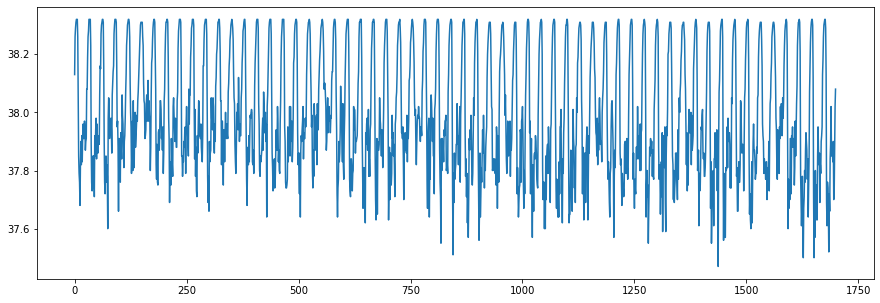

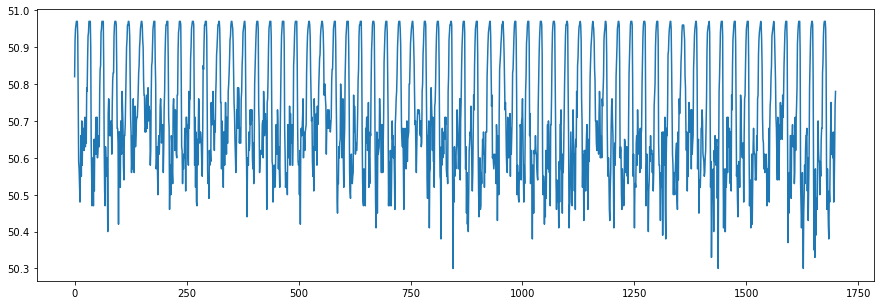

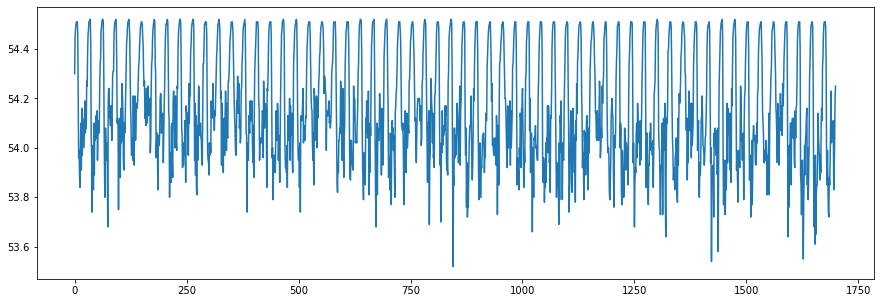

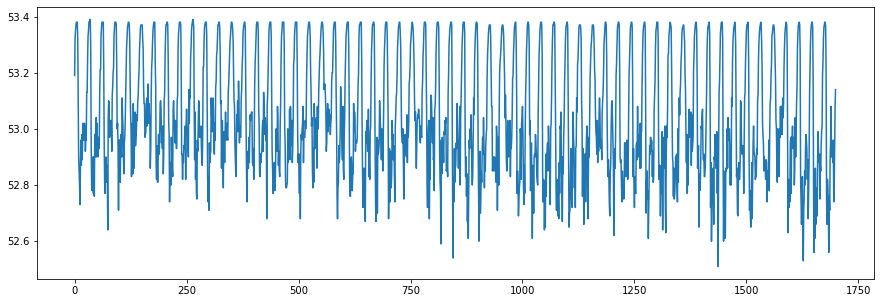

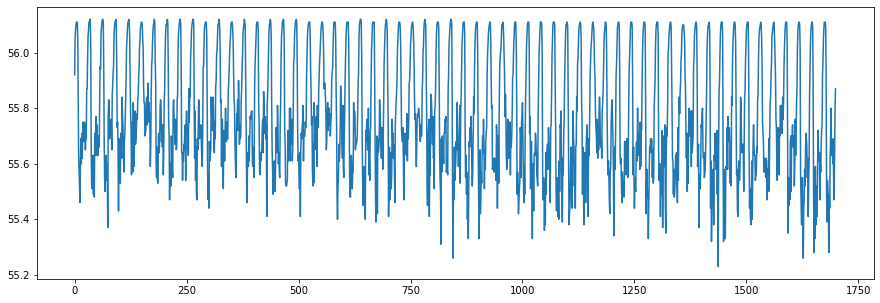

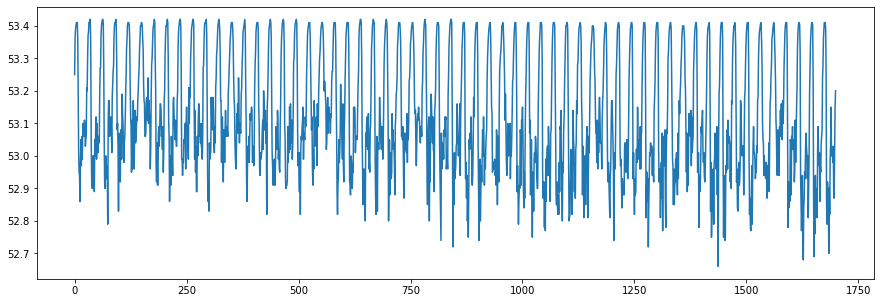

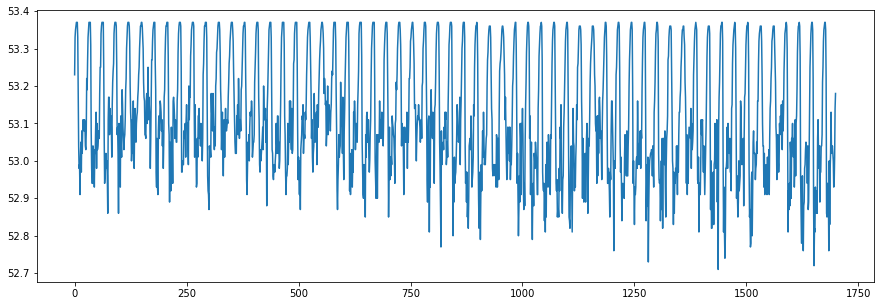

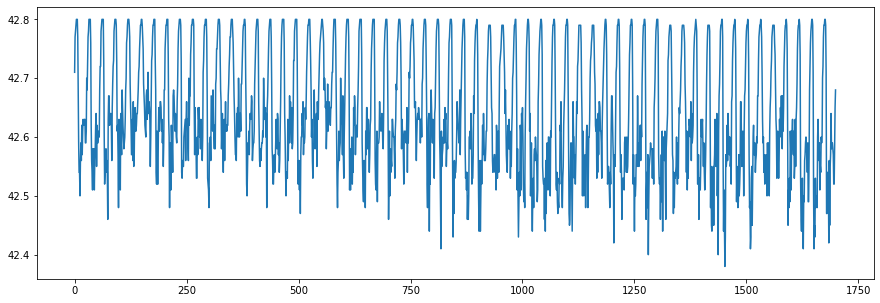

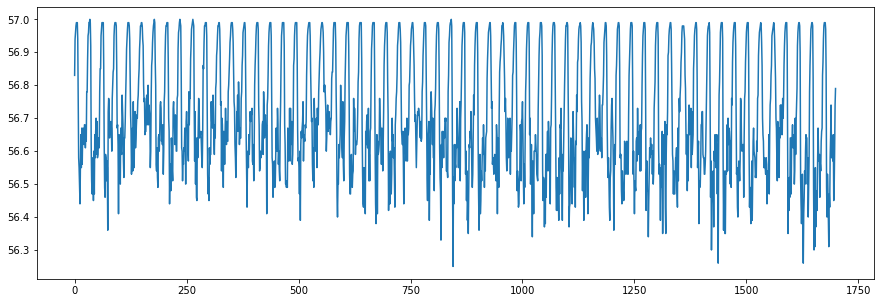

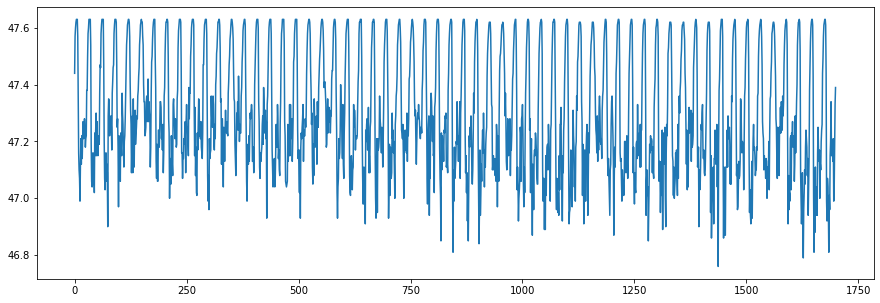

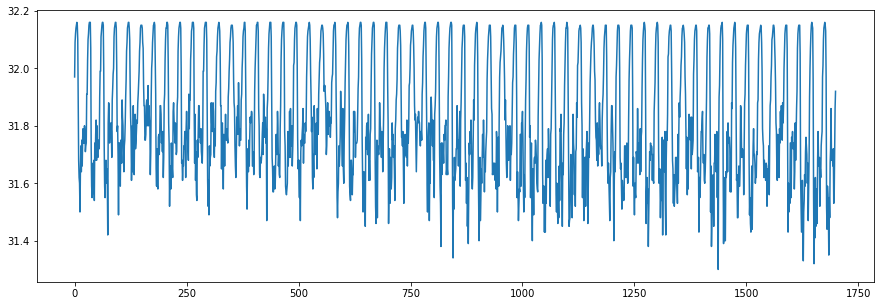

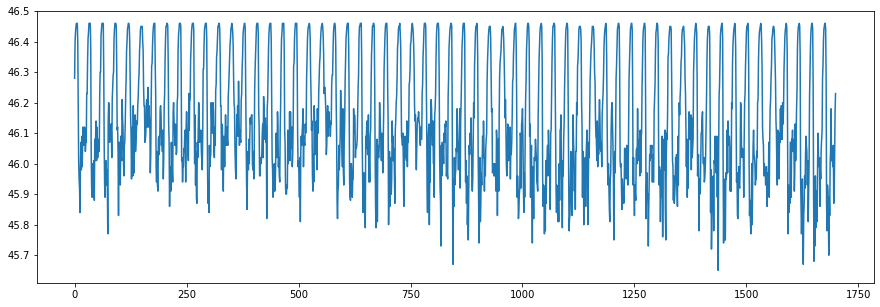

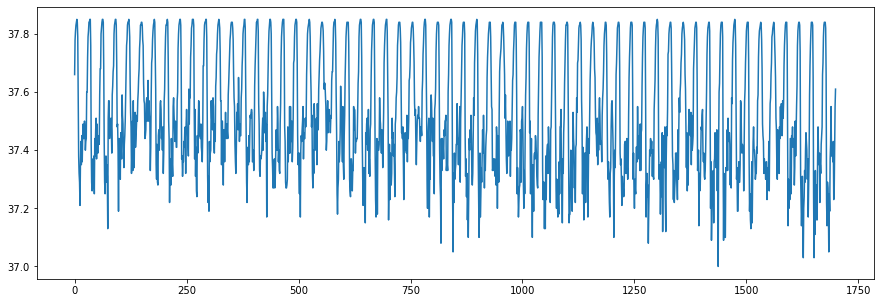

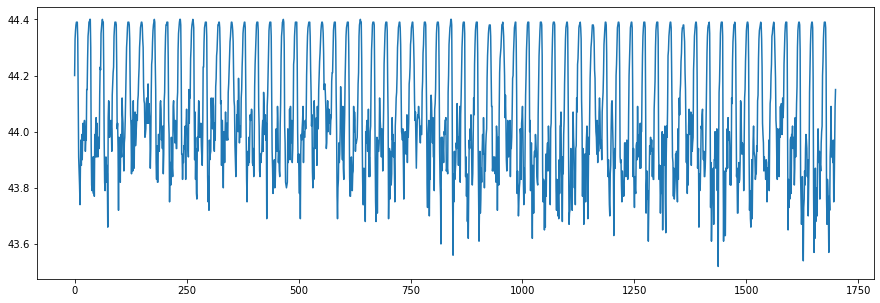

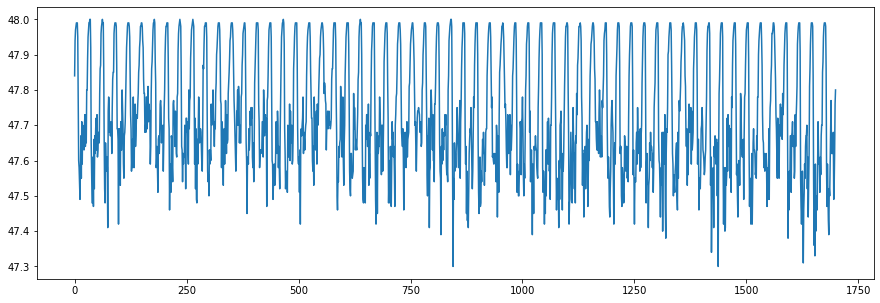

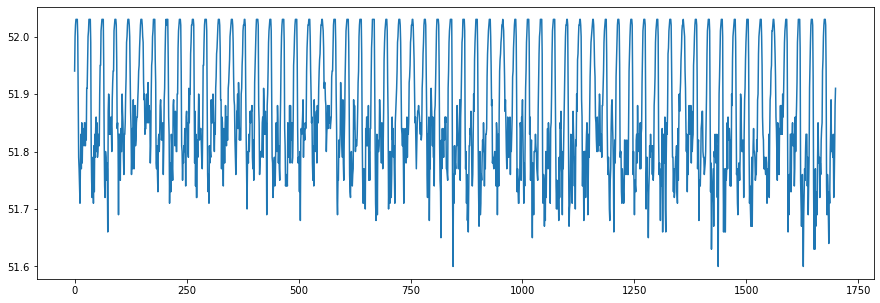

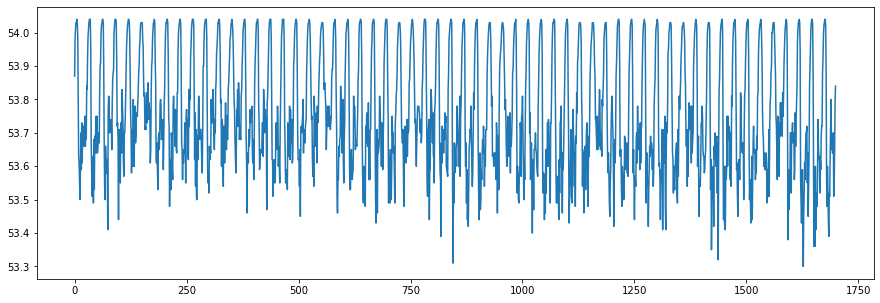

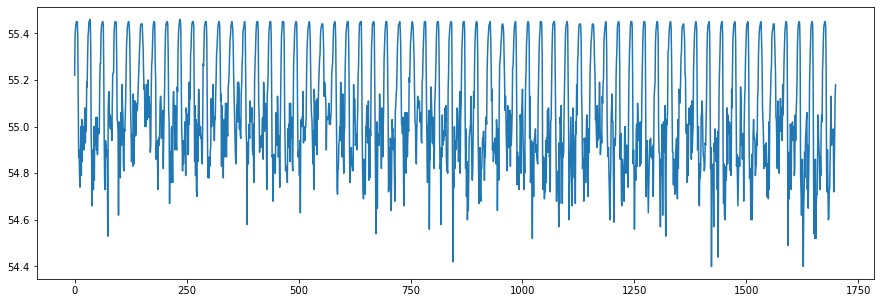

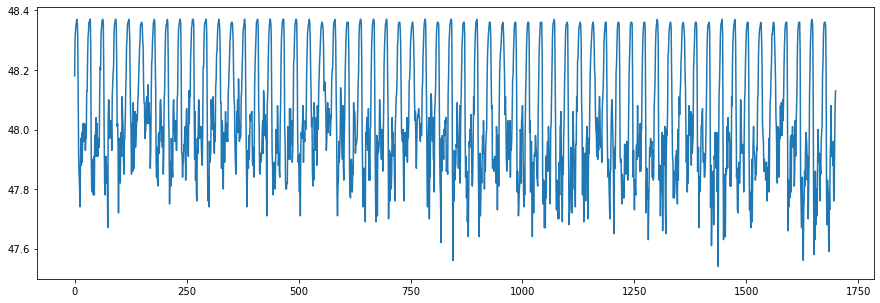

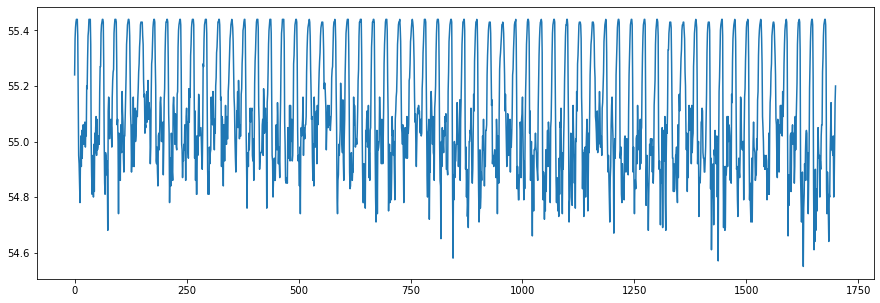

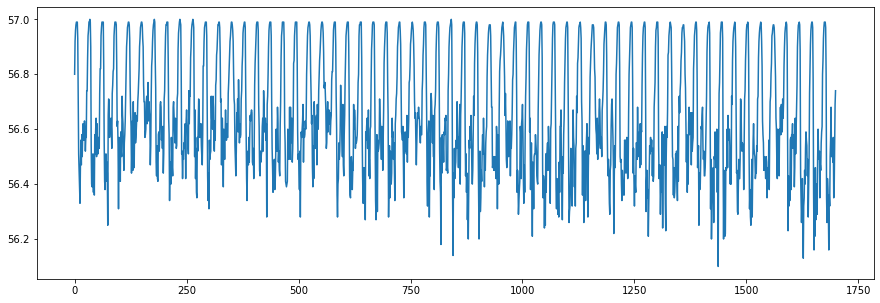

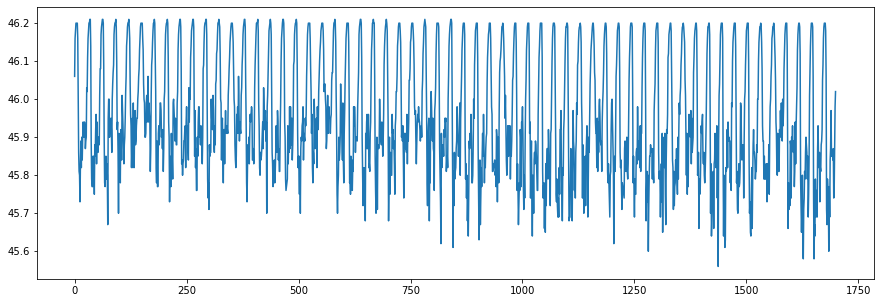

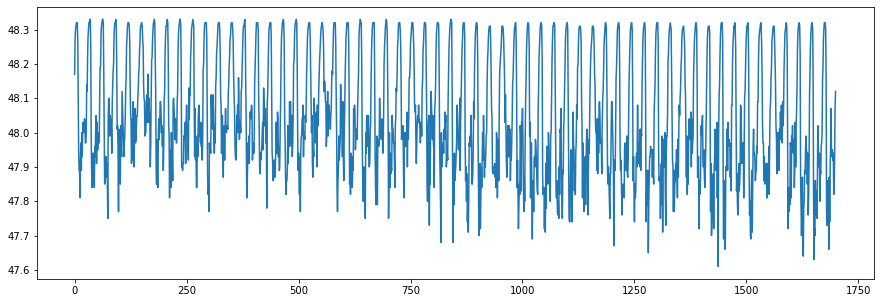

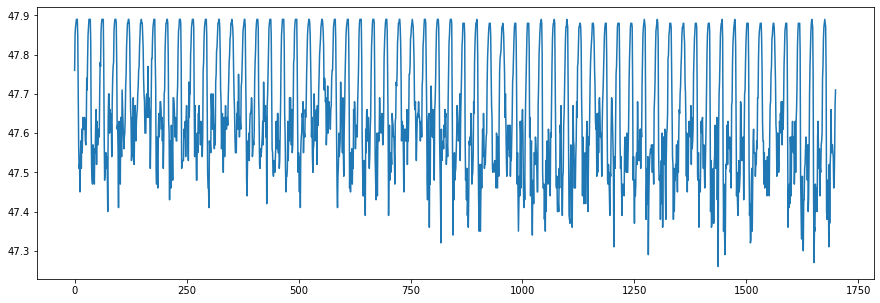

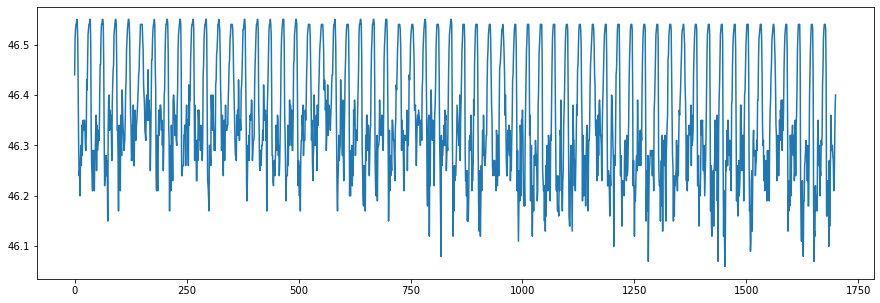

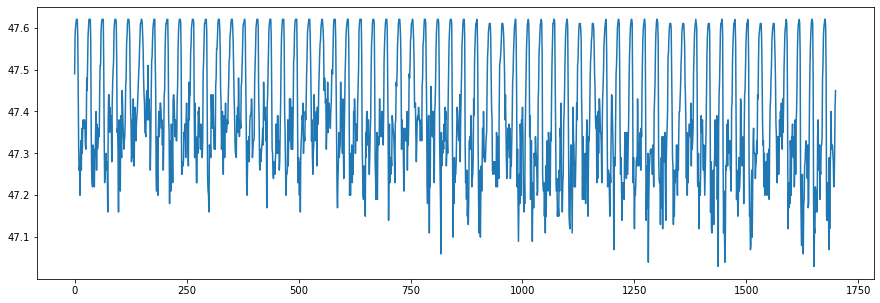

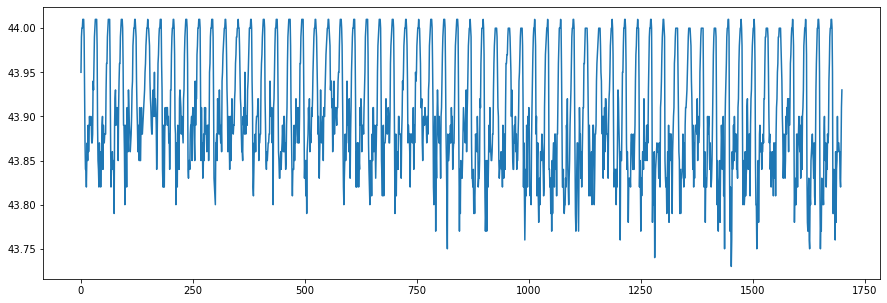

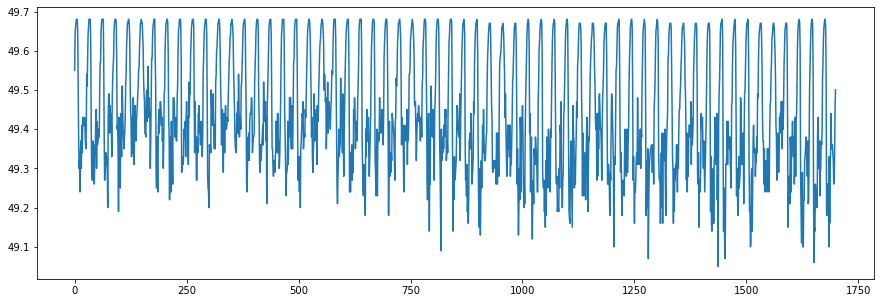

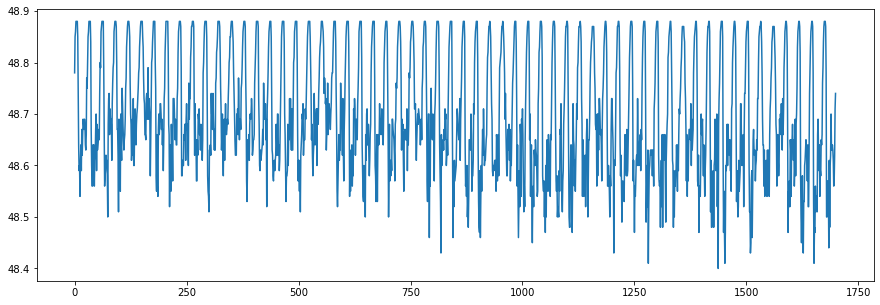

In [11]:
path = os.path.join(test_data_path_0, '1_leakage_test_data.parquet.gzip')
test_data = pd.read_parquet(path).to_numpy().astype(np.float32)
test_data

for i in range(29):
    plt.figure(figsize=(15,5))
    plt.plot(test_data[:,i][::10]);

In [182]:
X_1 = test_data[:, models[0]['inputs_idx']]
X_2 = test_data[:, models[1]['inputs_idx']]
X_3 = test_data[:, models[2]['inputs_idx']]


y_true_1 = test_data[:,0]
y_true_2 = test_data[:,1]
y_true_3 = test_data[:,2]


In [183]:
pred_1 = models[0]['model'].predict(X_1).flatten()
pred_2 = models[1]['model'].predict(X_1).flatten()
pred_3 = models[2]['model'].predict(X_1).flatten()

531/531 [==============================] - 2s 4ms/step


In [184]:
plt.figure(figsize=(15,5))
plt.plot(y_true_1);

In [185]:
#plt.figure(figsize=(15,5))
#plt.plot(pred_1[5000:])
#plt.plot(y_true_1[5000:])
#plt.show();

In [186]:
#plt.figure(figsize=(15,5))
#plt.plot(pred_2[:2000])
#plt.plot(y_true_2[:2000])
#plt.show();

In [187]:
#plt.figure(figsize=(15,5))
#plt.plot(pred_3[:2000])
#plt.plot(y_true_3[:2000])
#plt.show();

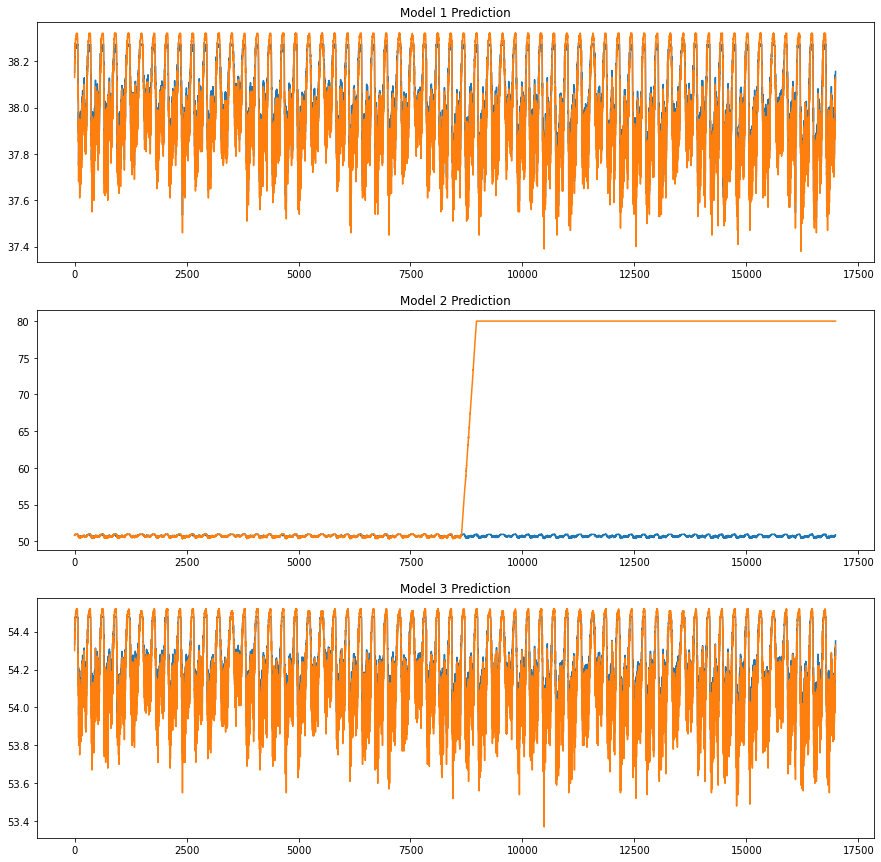

In [188]:
# Plots erstellen

seq_len = y_true_1.size
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].plot(pred_1[:seq_len])
axes[0].plot(y_true_1[:seq_len])
axes[0].set_title(f"Model 1 Prediction")

axes[1].plot(pred_2[:seq_len])
axes[1].plot(y_true_2[:seq_len])
axes[1].set_title(f"Model 2 Prediction")

axes[2].plot(pred_3[:seq_len])
axes[2].plot(y_true_3[:seq_len])
axes[2].set_title(f"Model 3 Prediction")
    
plt.show()

In [38]:
start = time.time()

In [39]:
end = time.time()

In [40]:
end-start

3.5399539470672607